# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Загрузим данные из файла

In [3]:
data = pd.read_csv('geo.csv',sep=';',decimal=",")

In [4]:
data.head()

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108806 entries, 0 to 108805
Data columns (total 4 columns):
Unnamed: 0       108806 non-null int64
x                108806 non-null float64
y                108806 non-null float64
comment_class    108806 non-null int64
dtypes: float64(2), int64(2)
memory usage: 3.3 MB


Файл не содержит пропущенных значений.   
Отобразим все значения на графике с разделением на За и Против.

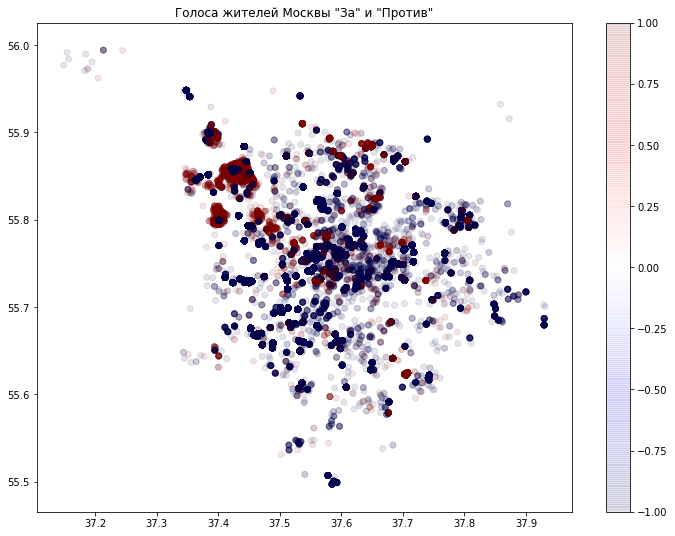

In [8]:
plt.figure(figsize=(12, 9))
plt.scatter(data.x, data.y, alpha=0.1,cmap=plt.cm.seismic,c=data.comment_class)
plt.title("Голоса жителей Москвы \"За\" и \"Против\"")
plt.colorbar()

In [9]:
data.describe()

,Unnamed: 0,x,y,comment_class
count,108806.000000,108806.000000,108806.000000,108806.000000
mean,54402.500000,37.567532,55.766346,-0.748929
std,31409.731032,0.121996,0.069622,0.662653
min,0.000000,37.148813,55.496939,-1.000000
25%,27201.250000,37.454528,55.729797,-1.000000
50%,54402.500000,37.559640,55.764734,-1.000000
75%,81603.750000,37.684784,55.806869,-1.000000
max,108805.000000,37.931228,55.994174,1.000000


Масштабируем данные, т.к. алгоритм кластеризации k-means чувствителен к масшатбу данных.

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['x','y']])

In [6]:
data_scaled=pd.concat([pd.DataFrame(data_scaled,columns=['x','y']),data.comment_class],axis=1)

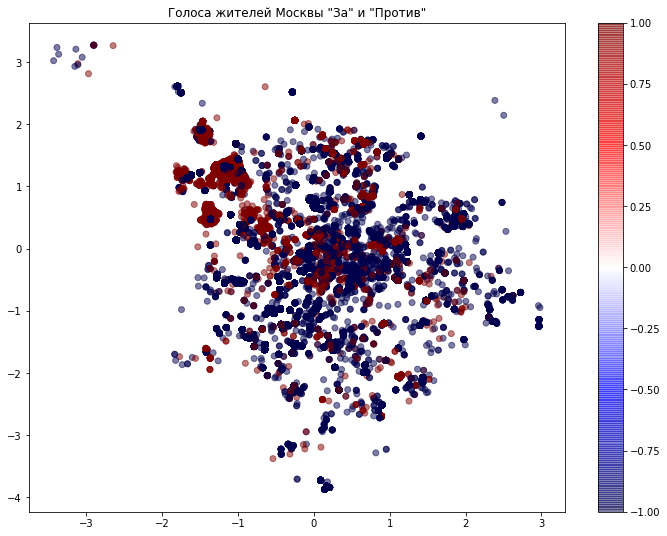

In [14]:
plt.figure(figsize=(12, 9))
plt.scatter(data_scaled.x, data_scaled.y,cmap=plt.cm.seismic,c=data_scaled.comment_class,alpha=0.5)
plt.title("Голоса жителей Москвы \"За\" и \"Против\"")
plt.colorbar()

In [1]:
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score

Т.к. округов в Москве 12, попробуем раздеить наши данные на 12 кластеров.

In [90]:
Kmeans=KMeans(n_clusters=12)
clusters = Kmeans.fit_predict(data_scaled[['x','y']])
#ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='autumn', s=60)
#ax.set_title(get_descr(algorithm.__class__.__name__, y, clusters, X_scaled))

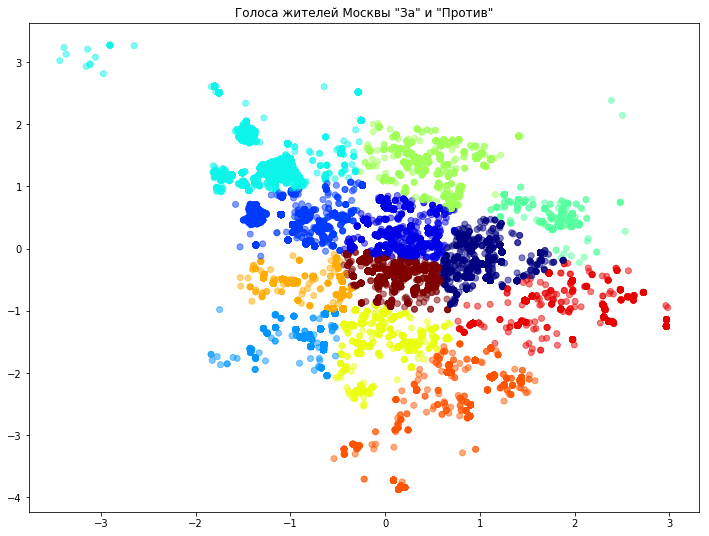

In [91]:
fig, axes = plt.subplots(1, 1, figsize=(12, 9))
axes.scatter(data_scaled.x, data_scaled.y,cmap=plt.cm.jet,c=clusters,alpha=0.5)
centers = Kmeans.cluster_centers_
#axes.scatter(centers[:, 0], centers[:, 1], s=100,c='Red',edgecolors='black')
axes.set_title("Голоса жителей Москвы \"За\" и \"Против\"");

На первый взгляд, мы взяли изыбточное кол-во кластеров. Попробуем найти оптимальное.

In [92]:
k_inertia = []
ks = range(4,12)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(data_scaled[['x','y']])
    k_inertia.append(clf_kmeans.inertia_)

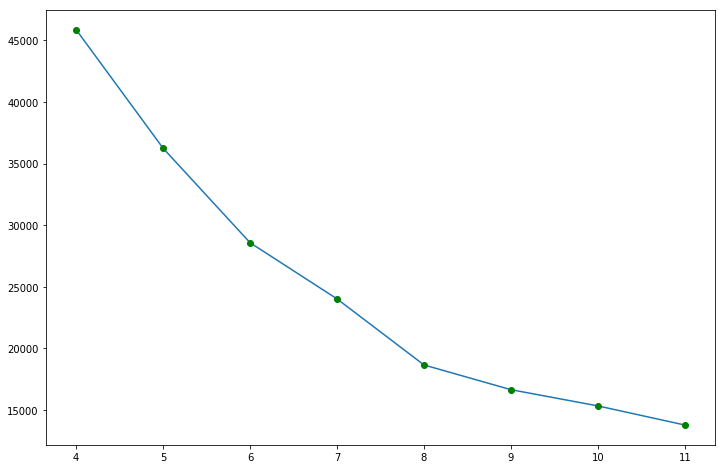

In [93]:
fig, axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(ks, k_inertia)
axes.set_xticks(range(1,12))
axes.plot(ks, k_inertia,'go')

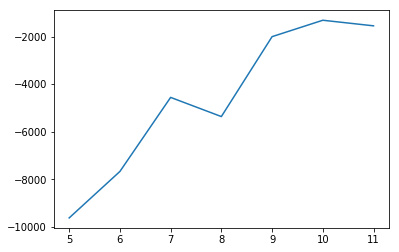

In [94]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

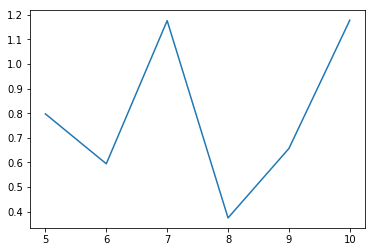

In [95]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [96]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

8

Оптимальное кол-во кластеров - 8

In [97]:
Kmeans=KMeans(n_clusters=8)
clusters = Kmeans.fit_predict(data_scaled[['x','y']])

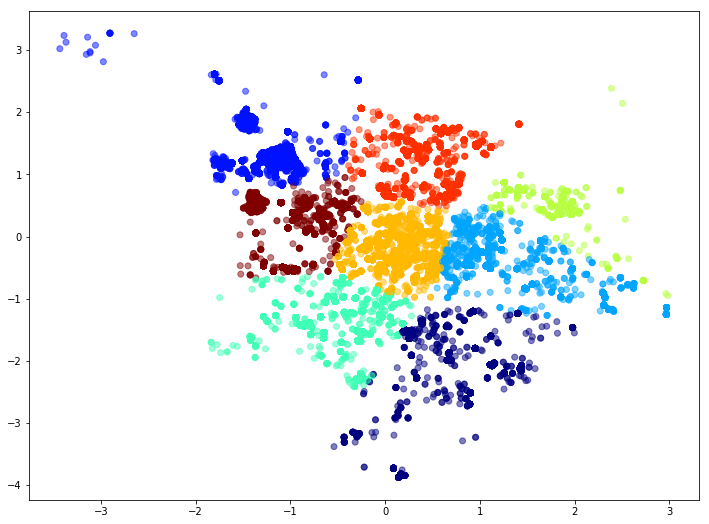

In [98]:
fig, axes = plt.subplots(1, 1, figsize=(12, 9))
axes.scatter(data_scaled.x, data_scaled.y,cmap=plt.cm.jet,c=clusters,alpha=0.5)
#centers = Kmeans.cluster_centers_
#axes.scatter(centers[:, 0], centers[:, 1], s=100,c='Red',edgecolors='black')

## Теперь проведем класстеризацию голосов за и против отдельно

Напишем функцию для поиска оптимального кол-ва кластеров:

In [72]:
def opt_nclusters(data,start_claster,end_claster):
    def_k_inretia=[]
    def_klusters=range(start_claster,end_claster)
    for i in def_klusters:
        def_k_means=KMeans(n_clusters=i)
        def_clusters_kmeans=def_k_means.fit_predict(data)
        def_k_inretia.append(def_k_means.inertia_) 
        
    diff = np.diff(def_k_inretia)    
    diff_r = diff[1:] / diff[:-1]    
    k_opt = def_klusters[np.argmin(diff_r)+1]
    return k_opt    

In [76]:
data_vote_for=data_scaled[data_scaled['comment_class']==1]
data_vote_against=data_scaled[data_scaled['comment_class']==-1]

Найдем птимальное кол-во кластеров для проголосоваших За и Против

In [99]:
opt_nclusters(data_vote_for[['x','y']],2,10)

3

In [100]:
opt_nclusters(data_vote_against[['x','y']],2,10)

3

Отобразим на графике разделение на кластере:

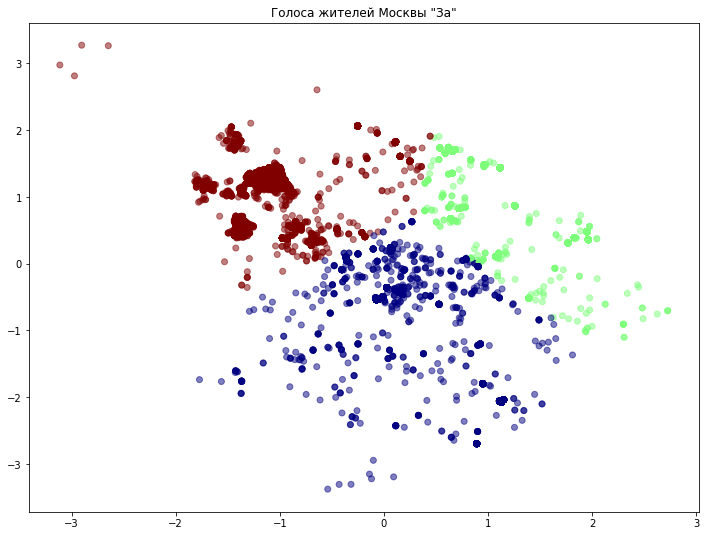

In [101]:
Kmeans=KMeans(n_clusters=3)
clusters = Kmeans.fit_predict(data_vote_for[['x','y']])
fig, axes = plt.subplots(1, 1, figsize=(12, 9))
axes.scatter(data_vote_for.x, data_vote_for.y,cmap=plt.cm.jet,c=clusters,alpha=0.5)
axes.set_title("Голоса жителей Москвы \"За\"");

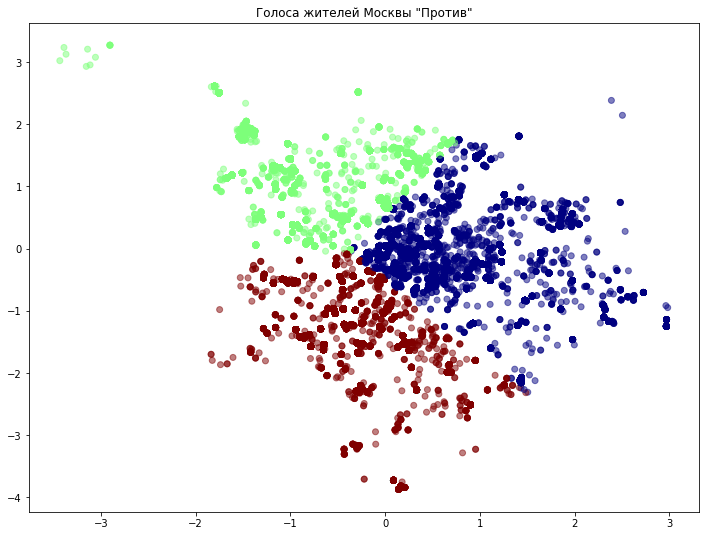

In [102]:
Kmeans=KMeans(n_clusters=3)
clusters = Kmeans.fit_predict(data_vote_against[['x','y']])
fig, axes = plt.subplots(1, 1, figsize=(12, 9))
axes.scatter(data_vote_against.x, data_vote_against.y,cmap=plt.cm.jet,c=clusters,alpha=0.5)
axes.set_title("Голоса жителей Москвы \"Против\"");

### Дополнительные задания    
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*

In [14]:
clf_DBSCAN = DBSCAN(eps=0.3,metric='euclidean',min_samples = 10000)
clusters = clf_DBSCAN.fit_predict(data_scaled[['x','y']])

In [15]:
np.unique(clusters)

array([-1,  0,  1,  2,  3], dtype=int64)

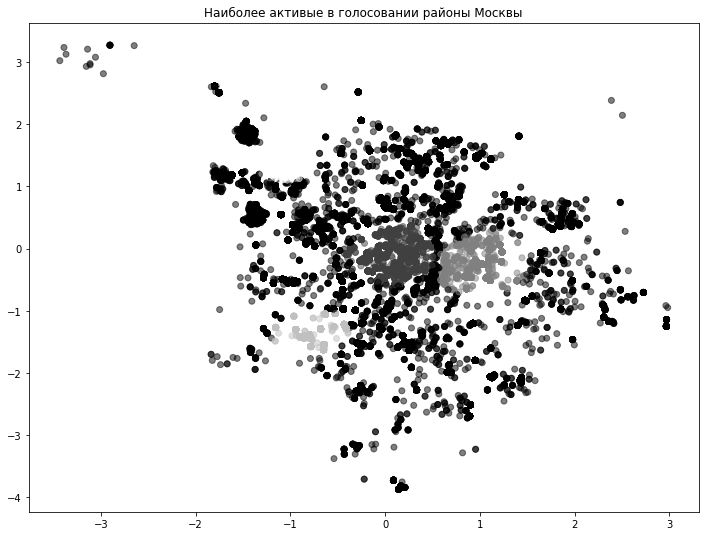

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(12, 9))
axes.scatter(data_scaled.x, data_scaled.y,cmap='gray',c=clusters,alpha=0.5)
axes.set_title("Наиболее активые в голосовании районы Москвы");